In [1]:
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
from PIL import Image
from selenium import webdriver
from IPython.display import clear_output

In [2]:
# Initializations
list_num = [i for i in map(int, open("../data/images/idxdata.csv", "r").read().split(","))]
label_names = [
    'Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney',
    'Crosswalk', 'Hydrant', 'Motorcycle', 'Other', 'Palm', 'Stair',
    'Traffic Light'
]

def save_progress():
    open("../data/images/idxdata.csv", "w").write(",".join(map(str, list_num)))

In [3]:
# WEB DRIVER FUNCTIONS
driver = webdriver.Chrome('../driver/chromedriver.exe')
driver.get("https://patrickhlauke.github.io/recaptcha/")
driver.fullscreen_window()

driver.switch_to.default_content()
driver.find_element_by_tag_name("iframe").click()
sleep(0.33)

# Find the right iframe in case of multiple redundant tags
iframes = [i for i in driver.find_elements_by_tag_name("iframe")]
correctIFrame = None
for i in iframes:
    driver.switch_to.frame(i)
    buttons = driver.find_elements_by_tag_name("button")
    if len(driver.find_elements_by_tag_name("button")) != 0:
        print("correct iframe found")
        correctIFrame = i
    driver.switch_to.default_content()    
driver.switch_to.frame(correctIFrame)

def reload():
    driver.find_element_by_tag_name("button").click()

def check_table():
    table_elements = []
    rows = driver.find_elements_by_tag_name("tr")
    for i in rows:
        columns = i.find_elements_by_tag_name("td")
        for j in columns:
            table_elements.append(j)
    return table_elements  

def img_element_with_id(id):
    images = driver.find_elements_by_tag_name("img")
    for i in images:
        if i.get_attribute("class") == "rc-image-tile-33":
            return i

# Get the correct captcha size and type (3x3)
def find_3x3_captcha():
    img_element = img_element_with_id("rc-image-tile-33")
    while img_element is None:
        reload()
        sleep(1)
        img_element = img_element_with_id("rc-image-tile-33")
    return check_table()

correct iframe found


In [4]:
# IMAGE FUNCTIONS
def download_image():
    urllib.request.urlretrieve(driver.find_element_by_class_name("rc-image-tile-33").get_attribute("src"), "../data/solver/captcha.jpeg")
    return Image.open("../data/solver/captcha.jpeg")

def show_image(img):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.array(img))
    plt.show()

def process_image(img):
    if img.mode == "RGBA":
        img = img.convert("RGB")
    img = img.resize((100, 100))
    return img

def crop_image(image):
    width, height = image.size
    grid_width = width // 3
    grid_height = height // 3
    cropped_images = []
    for i in range(3):
        for j in range(3):
            left = j * grid_width
            upper = i * grid_height
            right = (j + 1) * grid_width
            lower = (i + 1) * grid_height
            cropped = image.crop((left, upper, right, lower))
            cropped_images.append(process_image(cropped))
    return cropped_images

In [5]:
def validate_input():
    lower_case_labels = [i for i in map(str.lower, label_names)]
    print("VALID INPUTS: %s" % ", ".join(lower_case_labels))
    user_input = ""
    while user_input not in lower_case_labels:
        user_input = input(">")
    return lower_case_labels.index(user_input)


In [6]:
test = download_image()

In [7]:
crop_image(test)

[<PIL.Image.Image image mode=RGB size=100x100>,
 <PIL.Image.Image image mode=RGB size=100x100>,
 <PIL.Image.Image image mode=RGB size=100x100>,
 <PIL.Image.Image image mode=RGB size=100x100>,
 <PIL.Image.Image image mode=RGB size=100x100>,
 <PIL.Image.Image image mode=RGB size=100x100>,
 <PIL.Image.Image image mode=RGB size=100x100>,
 <PIL.Image.Image image mode=RGB size=100x100>,
 <PIL.Image.Image image mode=RGB size=100x100>]

In [8]:
def main():
    while True:
        sleep(2)
        find_3x3_captcha()
        images = crop_image(download_image())
        index = 0
        for i in images:
            clear_output()
            sleep(0.2)
            show_image(i)
            label_index = validate_input()
            i.save("../data/images/%s/%d.jpeg" % (label_names[label_index], list_num[label_index]))
            list_num[label_index] += 1
            index += 1
        clear_output()
        user_input = input("press enter to continue or type exit to quit")
        if user_input == "exit":
            break
    save_progress()
    print("Progress saved to idxdata.csv")

In [9]:
print(correctIFrame)

<selenium.webdriver.remote.webelement.WebElement (session="a7c549a933d3c62ca28e7d3192d53fe3", element="AFEEA0FDB5E3ADF4CEB74A3116C80BAD_element_6")>


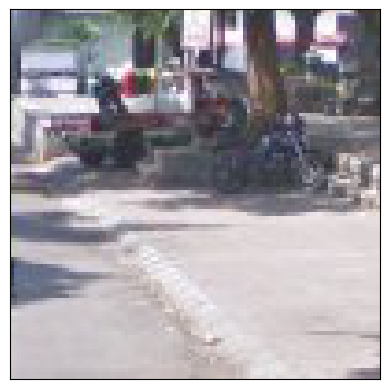

VALID INPUTS: bicycle, bridge, bus, car, chimney, crosswalk, hydrant, motorcycle, other, palm, stair, traffic light
you chose: Motorcycle
Progress saved to idxdata.csv


In [10]:
main()